In [1]:
import json
import cv2
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm
import csv
import random
import hashlib
import numpy as np
import os
from operator import itemgetter 
from os import listdir
from os.path import isfile, join
import pandas as pd

DIR_PATH = '/Users/alexdrozdz/Desktop/Studia/00. Seminarium magisterskie/'

In [2]:
# splitted metadata
with open(DIR_PATH + "Master_degree/additional_data/train_80_percent.json") as jsonFile:
    train_set = json.load(jsonFile)
    jsonFile.close()
    
with open(DIR_PATH + "Master_degree/additional_data/val_20_percent.json") as jsonFile:
    test_set = json.load(jsonFile)
    jsonFile.close()

In [3]:
# get names of files from original train val split
train_names = [
    " ".join(train_set['images'][i]['url'].split('/')[-4:]).replace(' ', '_') for i in range(len(train_set['images']))
]

test_names = [
    " ".join(test_set['images'][i]['url'].split('/')[-4:]).replace(' ', '_') for i in range(len(test_set['images']))
]

In [4]:
len(train_names), len(test_names)

(2846, 712)

In [5]:
len(train_names) + len(test_names)

3558

In [6]:
# additional validation set
hashnums_train = [int(hashlib.md5(str(name).encode('Utf-8')).digest()[-1]) for name in train_names]

hashnums_val = list(filter(lambda hashnum: hashnum < 0.08 * 256, hashnums_train))

In [7]:
len(hashnums_val)/len(hashnums_train)

0.08081517919887561

In [8]:
indexes_val = [i for i, e in enumerate(hashnums_train) if e in list(dict.fromkeys(hashnums_val))]

In [9]:
val_names = itemgetter(*indexes_val)(train_names)

In [10]:
train_names = [name for name in train_names if name not in val_names]

In [11]:
len(train_names), len(test_names), len(val_names)

(2616, 712, 230)

In [12]:
# get metadata and save everything in appropriate format
file = open(DIR_PATH + "Master_degree/additional_data/beyond_words.txt", "r")

contents = file.read()
metadata = ast.literal_eval(contents)

file.close()

In [16]:
metadata['data']

[{'id': '5dd0a64bf3504300010034d4',
  'location': {'standard': 'http://s3.amazonaws.com/ndnp-jpeg-surrogates/pst_davey_ver01/data/sn83045211/0023728768A/1917090801/0807.jpg'},
  'region': {'toolName': 'rectangleTool',
   'color': '#fe0000',
   'x': 720.3651718691601,
   'y': 216.61960690887446,
   'width': 4196.375082367921,
   'height': 1153.6253484216786,
   'label': 'Illustration/Photo'},
  'width': 5088,
  'height': 6608,
  'meta_data': {'set_key': 'http://chroniclingamerica.loc.gov/lccn/sn83045211/1917-09-08/ed-1/seq-11/',
   'subject_url': 'http://chroniclingamerica.loc.gov/lccn/sn83045211/1917-09-08/ed-1/seq-11/',
   'subject_description': 'Evening public ledger. September 08, 1917. Page 11',
   'resize': '1.000000',
   'alto': 'http://s3.amazonaws.com/ndnp-batches/pst_davey_ver01/data/sn83045211/0023728768A/1917090801/0807.xml'},
  'data': {'values': [{'caption': 'PETEY—Right Away Petey Pulls a Boner',
     'creator': 'C. A. VOIGHT',
     'category': 'Comics/Cartoon'}],
   'tas

In [13]:
cats, ps, x0s, y0s, x1s, y1s = [], [], [], [], [], []

for i in tqdm(range(len(metadata['data']))):
    try:
        try:
            cat = metadata['data'][i]['data']['category']
        except:
            cat = metadata['data'][i]['data']['values'][0]['category']
    except:
        print(f'Label for photo number: {i} not found, photo skipped')
        continue
    
    if cat == 'Photograph':
        cat = 0
    elif cat == 'Illustration':
        cat = 1
    elif cat == 'Map':
        cat = 2
    elif cat == 'Comics/Cartoon':
        cat = 3
    elif cat == 'Editorial Cartoon':
        cat = 4
    elif cat == 'Headline':
        cat = 5
    elif cat == 'Advertisement':
        cat = 6
        
    cats.append(cat)
    
    ps.append(" ".join(metadata['data'][i]['location']['standard'].split('/')[-4:]).replace(' ', '_'))
    
    x0s.append(int(float(metadata['data'][i]['region']['x'])))
    y0s.append(int(float(metadata['data'][i]['region']['y'])))
    x1s.append(int(float(metadata['data'][i]['region']['x']) + float(metadata['data'][i]['region']['width'])))
    y1s.append(int(float(metadata['data'][i]['region']['y']) + float(metadata['data'][i]['region']['height'])))

Label for photo number: 3062 not found, photo skipped
Label for photo number: 4043 not found, photo skipped
Label for photo number: 4412 not found, photo skipped
Label for photo number: 4616 not found, photo skipped
Label for photo number: 4625 not found, photo skipped
Label for photo number: 4645 not found, photo skipped
Label for photo number: 4957 not found, photo skipped
Label for photo number: 5865 not found, photo skipped
Label for photo number: 6024 not found, photo skipped
Label for photo number: 6025 not found, photo skipped
Label for photo number: 6036 not found, photo skipped
Label for photo number: 6040 not found, photo skipped
Label for photo number: 6071 not found, photo skipped
Label for photo number: 6164 not found, photo skipped
Label for photo number: 6188 not found, photo skipped
Label for photo number: 6194 not found, photo skipped
Label for photo number: 6216 not found, photo skipped
Label for photo number: 6356 not found, photo skipped
Label for photo number: 6378

In [14]:
no_duplicated_names = list(dict.fromkeys(ps))

In [15]:
len(no_duplicated_names)

3429

In [16]:
list_of_indexes_lists = []
for name in no_duplicated_names:
    list_of_indexes_lists.append([i for i, e in enumerate(ps) if e == name])

In [17]:
multi_elem_list = []
names_list = []
for j, i in enumerate(list_of_indexes_lists):
    temp_list = []
    names_list.append(no_duplicated_names[j])
    for e in range(len(i)):
        temp_list.append(f'{cats[i[e]]}/{x0s[i[e]]},{y0s[i[e]]},{x1s[i[e]]},{y1s[i[e]]}/{30}')
    
    multi_elem_list.append(temp_list)

In [18]:
new_train_set, new_test_set, new_val_set = [], [], []
train_name_list, test_name_list, val_name_list = [], [], []

for i, name in enumerate(names_list):
    if name in train_names:
        train_name_list.append(name)
        new_train_set.append(multi_elem_list[i])
    elif name in test_names:
        test_name_list.append(name)
        new_test_set.append(multi_elem_list[i])
    elif name in val_names:
        val_name_list.append(name)
        new_val_set.append(multi_elem_list[i])
    else:
        print(f"{name} doesn't exist in any set")

sn85058246_00206536263_1917063001_0656.jpg doesn't exist in any set


In [19]:
len(new_train_set), len(new_test_set), len(new_val_set)

(2514, 690, 224)

In [20]:
len(train_name_list), len(test_name_list), len(val_name_list)

(2514, 690, 224)

In [21]:
# check if every file is correct
scraped_photos = [
    f for f in listdir(DIR_PATH + 'scraped_photos/') if isfile(join(DIR_PATH + 'scraped_photos/', f))
]

scraped_photos.remove('.DS_Store')

In [22]:
check_list = train_name_list + test_name_list + val_name_list

good, bad = [], []
for i in check_list:
    if i in scraped_photos:
        good.append(1)
    else:
        bad.append(1)
        
print(f'Number of matched photos: {sum(good)}')
print(f'Number of not matched photos: {sum(bad)}')
print(f'Number of missing metadata compared to their train-test splitted set: {len(scraped_photos) - len(check_list)}')

Number of matched photos: 3428
Number of not matched photos: 0
Number of missing metadata compared to their train-test splitted set: 127


In [23]:
def show_random_img(names_list, coordinates_list, path_to_photos):
    random_img = random.randint(0,len(names_list))
    print(names_list[random_img])
    random_adnotation = random.randint(0,len(coordinates_list[random_img])-1)
    variables = coordinates_list[random_img][random_adnotation].split('/')
    coordinates = variables[1].split(',')
    x0, y0 = coordinates[0], coordinates[1]
    x1, y1 = coordinates[2], coordinates[3]

    box = cv2.rectangle(
        cv2.imread(
            path_to_photos + names_list[random_img]
        ),
        (int(x0), int(y0)), 
        (int(x1), int(y1)), 
        (0, 255, 0), 
        thickness=10, 
    )

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(box, cmap='gray')

sn83045211_00237282504_1918092501_1114.jpg


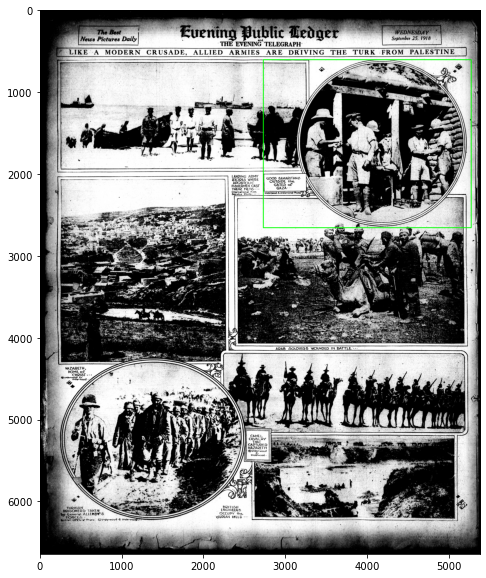

In [24]:
show_random_img(
    names_list = train_name_list + test_name_list + val_name_list,
    coordinates_list = new_train_set + new_test_set + new_val_set,
    path_to_photos = DIR_PATH + 'scraped_photos/',
)

In [25]:
def final_input_transformer(input_list):
    final_list = []
    for i in range(len(input_list)):
        final_list.append(";".join(input_list[i]))
        
    return final_list

In [26]:
final_train_set = final_input_transformer(new_train_set)
final_test_set = final_input_transformer(new_test_set)
final_val_set = final_input_transformer(new_val_set)

In [27]:
# categories distribution
categories = []

for i in final_train_set:
    splitted = i.split(';')
    if len(splitted) > 1:
        for e in splitted:
            categories.append(e.split('/')[0])
    else:
        categories.append(i.split('/')[0])
    
for i in final_test_set:
    splitted = i.split(';')
    if len(splitted) > 1:
        for e in splitted:
            categories.append(e.split('/')[0])
    else:
        categories.append(i.split('/')[0])
    
for i in final_val_set:
    splitted = i.split(';')
    if len(splitted) > 1:
        for e in splitted:
            categories.append(e.split('/')[0])
    else:
        categories.append(i.split('/')[0])
    
cat_series = pd.Series(categories)

cat_series = cat_series.map({
    '0': 'fotografia', 
    '1': 'ilustracja',
    '2': 'mapa', 
    '3': 'komiks/karykatura',
    '4': 'karykatura polityczna', 
    '5': 'nagłówek',
    '6': 'reklama',
})

cat_series.value_counts()

fotografia               4193
komiks/karykatura        1139
ilustracja               1027
karykatura polityczna     293
mapa                       79
dtype: int64

In [28]:
# save files in final shape
def save_list_to_tsv_file(path, output_list):
    with open(path, 'w', newline='') as f_output:
        tsv_output = csv.writer(f_output, delimiter='\t')
        tsv_output.writerow(output_list)

In [29]:
# train:
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/train/expected.tsv', final_train_set)
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/train/in.tsv', train_name_list)

# test:
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/test-A/expected.tsv', final_test_set)
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/test-A/in.tsv', test_name_list)

# val:
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/dev-0/expected.tsv', final_val_set)
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/dev-0/in.tsv', val_name_list)